# 🧠 Human-in-the-Loop (HITL) or Human Feedback at Runtime

## 🔍 What is it?

**Human-in-the-loop (HITL)** or **runtime human feedback** means that a human supervises, intervenes, or provides input during the execution of an AI agent or system — *while it's running*.

Instead of the agent acting fully autonomously, it **pauses at certain points** or **asks for human confirmation** before proceeding.

---

## ✅ Example Scenarios

### 📧 Email Generation Agent
> Agent drafts an email → human approves or edits → then it sends.

### 🔎 Multi-step Research Agent
> Agent finds 5 articles → asks human to select the most relevant → then summarizes only the selected ones.

### 💬 Customer Support Agent
> Agent suggests replies → human support agent selects the best one or modifies it → sends to the customer.

### 🧩 LangGraph Agent Example
> Agent completes a subtask → pauses → human validates → moves to next subtask or corrects.

---

## 🌟 Benefits of Human-in-the-Loop

| Benefit                 | Description                                                                 |
|-------------------------|-----------------------------------------------------------------------------|
| ✅ Increased Accuracy    | Humans catch and correct mistakes in real-time.                            |
| 🔐 Better Control & Safety | Prevents the system from taking harmful or incorrect actions.              |
| 🧠 Improved Learning     | Human feedback can be used to refine future agent decisions (e.g., RLHF).  |
| 💬 Trust Building        | Users feel more confident knowing a human oversees the process.            |
| 📉 Error Reduction       | Especially important in high-stakes domains like healthcare or finance.   |
| 📈 Customizability       | Human can steer the task based on goals or context not in training data.   |

---

## 🧩 HITL vs. Fully Autonomous Agents

| Aspect      | Human-in-the-Loop                      | Fully Autonomous                  |
|-------------|----------------------------------------|-----------------------------------|
| Accuracy     | Higher (with human corrections)        | Lower (depends only on model)     |
| Speed        | Slower                                 | Faster                            |
| Safety       | Safer (human checks)                   | Riskier                           |
| Use Cases    | Research, legal, medical               | Routine, low-risk tasks           |


In [2]:
from dotenv import load_dotenv
load_dotenv()
import os

from langchain_groq import ChatGroq


#os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")


llm=ChatGroq(model="qwen/qwen3-32b")
#llm = ChatOpenAI(model="gpt-4o")
result=llm.invoke("Hello")
result


AIMessage(content='<think>\nOkay, the user said "Hello". That\'s a simple greeting. I should respond in a friendly and welcoming way. Maybe add an emoji to keep it warm. Let me make sure there\'s no hidden context here. Since it\'s just a hello, I can offer help. Something like "Hi there! 😊 How can I assist you today?" That should work. Keep it open-ended so they know I\'m here to help with whatever they need.\n</think>\n\nHi there! 😊 How can I assist you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 109, 'prompt_tokens': 9, 'total_tokens': 118, 'completion_time': 0.249584155, 'prompt_time': 0.000177617, 'queue_time': 0.006219169, 'total_time': 0.249761772}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_f17c2eb555', 'finish_reason': 'stop', 'logprobs': None}, id='run--ba704cf4-591c-4a9b-a3b1-99641d5a281f-0', usage_metadata={'input_tokens': 9, 'output_tokens': 109, 'total_tokens': 118})

## Making custom tool

In [3]:
### Custom tools
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

def divide(a: int, b: int) -> float:
    """Divide a by b.

    Args:
        a: first int
        b: second int
    """
    return a / b

tools=[add,multiply,divide]
tools



[<function __main__.add(a: int, b: int) -> int>,
 <function __main__.multiply(a: int, b: int) -> int>,
 <function __main__.divide(a: int, b: int) -> float>]

In [4]:
## Integrate tools with llm
llm_with_tools=llm.bind_tools(tools)
llm_with_tools

RunnableBinding(bound=ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x00000251E30C0110>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x00000251E1245990>, model_name='qwen/qwen3-32b', model_kwargs={}, groq_api_key=SecretStr('**********')), kwargs={'tools': [{'type': 'function', 'function': {'name': 'add', 'description': 'Adds a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'multiply', 'description': 'Multiply a and b.', 'parameters': {'properties': {'a': {'description': 'first int', 'type': 'integer'}, 'b': {'description': 'second int', 'type': 'integer'}}, 'required': ['a', 'b'], 'type': 'object'}}}, {'type': 'function', 'function': {'name': 'divide', 'description': 'Divide a by b.', 'parameters': {'properties': {'a': {'description': 'first int',

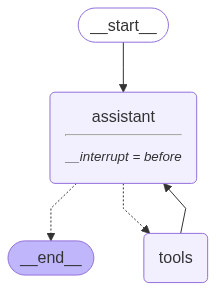

In [5]:
### WWorkflow with Langgraph
from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage

## system Message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")

## node definition
def assistant(state:MessagesState):
    return {"messages":[llm_with_tools.invoke([sys_msg] + state["messages"])]}

#Graph
builder=StateGraph(MessagesState)

## Define nodes: 
builder.add_node("assistant",assistant)
builder.add_node("tools",ToolNode(tools))

## Define the Edges

builder.add_edge(START,"assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,

)
builder.add_edge("tools","assistant")

memory=MemorySaver()

### human in the loop
graph=builder.compile(interrupt_before=["assistant"],checkpointer=memory)

# Show
display(Image(graph.get_graph().draw_mermaid_png()))






In [6]:
thread={"configurable":{"thread_id":"123"}}
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

In [7]:
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [8]:
state=graph.get_state(thread)
state.next

('assistant',)

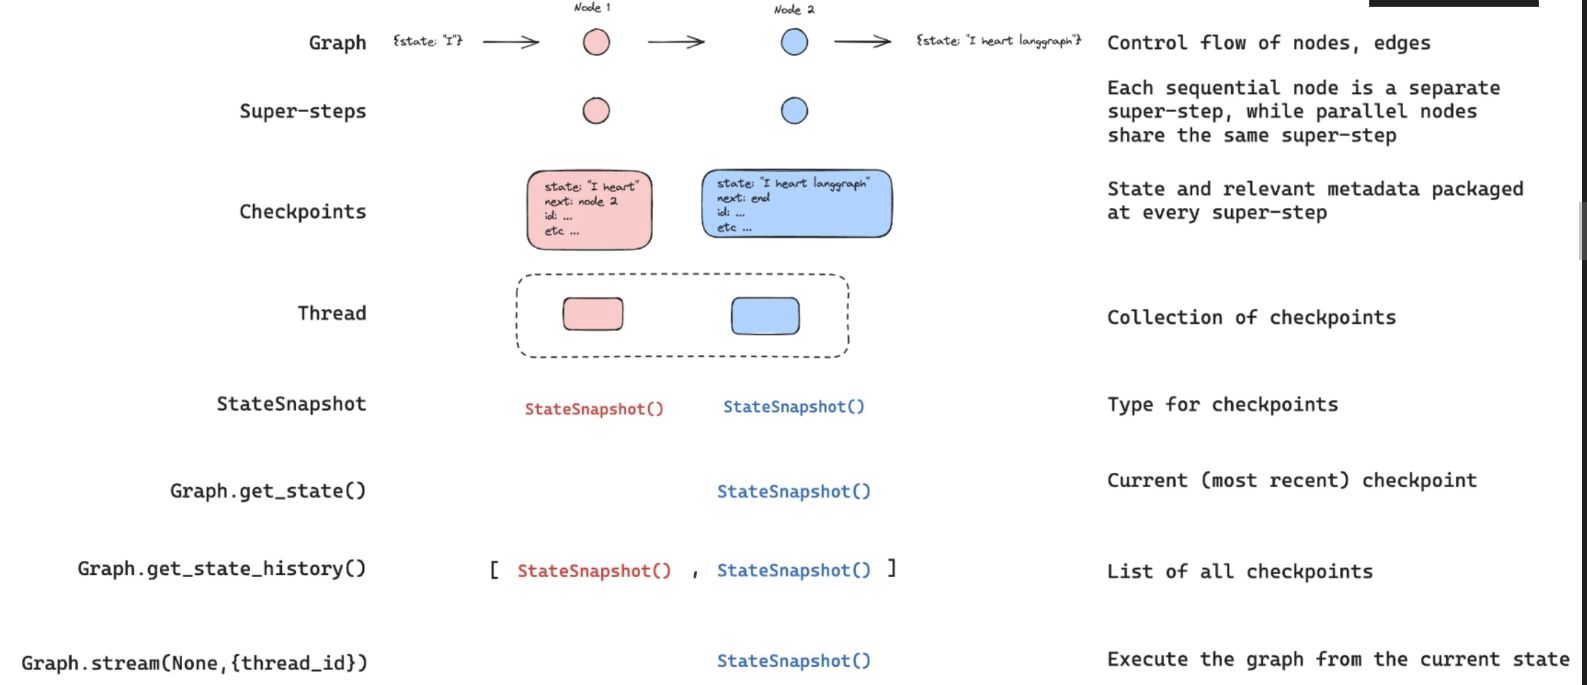

## Continue the execution to Assistant

In [9]:

for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================== Ai Message ==================================
Tool Calls:
  multiply (zadhrj4ws)
 Call ID: zadhrj4ws
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: multiply

6


In [10]:
state=graph.get_state(thread)
state.next

('assistant',)

In [11]:
## Continue the execution of Assistant and then end
for event in graph.stream(None,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

6
================================== Ai Message ==================================

The product of 2 and 3 is **6**.


## Edit Human Feedback

In [12]:
initial_input={"messages":HumanMessage(content="Multiply 2 and 3")}

thread={"configurable":{"thread_id":"1"}}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3


In [13]:
graph.update_state(thread,{"messages":[HumanMessage(content="No,please multiply 15 and 6")]})

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f064647-1f7e-6a01-8001-fda640cc045b'}}

In [14]:
new_state=graph.get_state(thread).values

for m in new_state['messages']:
    m.pretty_print()


================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

No,please multiply 15 and 6


In [15]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

No,please multiply 15 and 6
================================== Ai Message ==================================
Tool Calls:
  multiply (v2j5m0a74)
 Call ID: v2j5m0a74
  Args:
    a: 15
    b: 6
================================= Tool Message =================================
Name: multiply

90


In [16]:
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: multiply

90
================================== Ai Message ==================================

The result of multiplying 15 and 6 is $\boxed{90}$.


### Workflow will Wait for the User Input

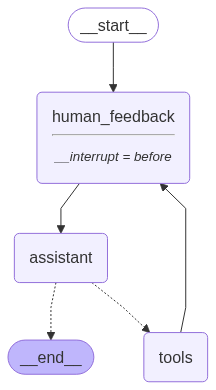

In [17]:
# System message
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")


## Human feedback node

def human_feedback(state:MessagesState):
    pass

### Assistant node
def assistant(state:MessagesState):
    return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

## Graph

# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))
builder.add_node("human_feedback", human_feedback)


## Define the edges
builder.add_edge(START,"human_feedback")
builder.add_edge("human_feedback","assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools","human_feedback")

memory=MemorySaver()
graph=builder.compile(interrupt_before=["human_feedback"],checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))


In [18]:
# Input
initial_input = {"messages": "Multiply 2 and 3"}

# Thread
thread = {"configurable": {"thread_id": "5"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

## get user input

user_input=input("Tell me how you want to update the state:")
graph.update_state(thread,{"messages":user_input},as_node="human_feedback")

# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Multiply 2 and 3
================================ Human Message =================================

please add 2 and 3
================================== Ai Message ==================================
Tool Calls:
  add (h092tk8p7)
 Call ID: h092tk8p7
  Args:
    a: 2
    b: 3
================================= Tool Message =================================
Name: add

5


In [19]:
# Continue the graph execution
for event in graph.stream(None, thread, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: add

5
================================== Ai Message ==================================

The result of adding 2 and 3 is **5**.
